<a href="https://colab.research.google.com/github/crazyandiee/Customer-Churn-Prediction-System-with-Dashboard-Web-App/blob/main/notebooks/Model_Training_%26_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv("/content/telco_cleaned.csv")
print("✅ Cleaned dataset loaded:", df.shape)

✅ Cleaned dataset loaded: (7043, 36)


In [4]:
#Split Features/Target

X = df.drop(columns=["Churn", "tenure_group"])  # drop non-numeric categorical
y = df["Churn"]

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (5634, 34), Test size: (1409, 34)


In [6]:
#Feature Scaling

scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [7]:
#Train Models

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6
)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [9]:
#Evaluation Function

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    print(f"\n📊 {name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} - ROC Curve")
    plt.show()

    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}


📊 Logistic Regression Performance:
Accuracy:  0.8062
Precision: 0.6583
Recall:    0.5615
F1 Score:  0.6061
ROC-AUC:   0.8425


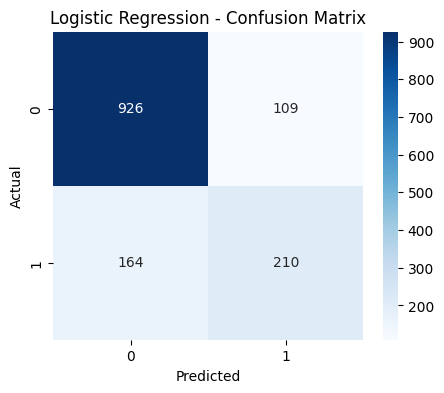

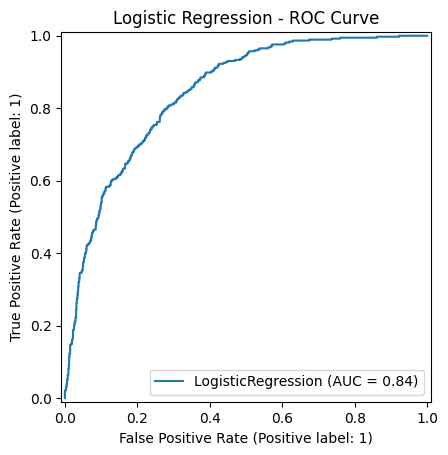


📊 Random Forest Performance:
Accuracy:  0.7864
Precision: 0.6174
Recall:    0.5134
F1 Score:  0.5606
ROC-AUC:   0.8259


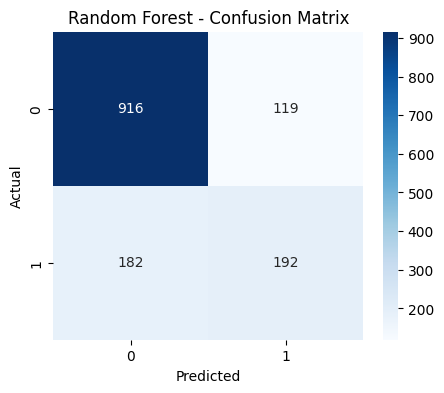

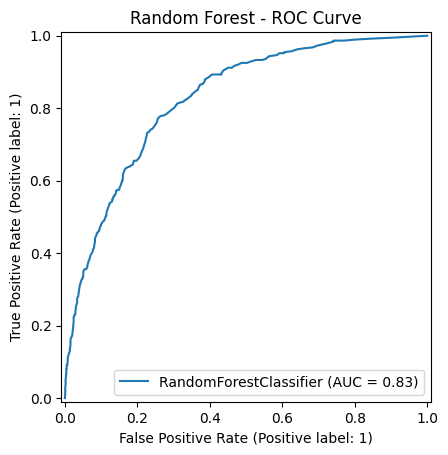


📊 XGBoost Performance:
Accuracy:  0.7956
Precision: 0.6387
Recall:    0.5294
F1 Score:  0.5789
ROC-AUC:   0.8399


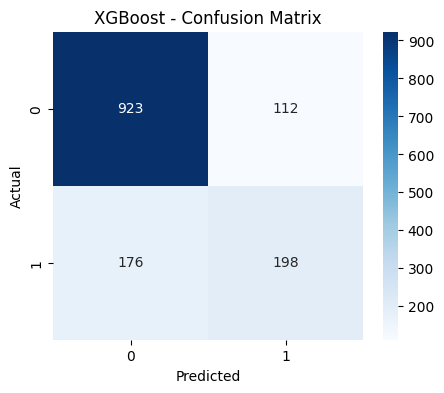

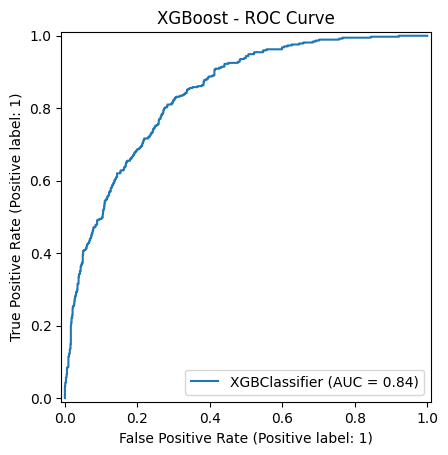


🏁 Model Comparison:
                 model  accuracy  precision    recall        f1   roc_auc
0  Logistic Regression  0.806246   0.658307  0.561497  0.606061  0.842450
2              XGBoost  0.795600   0.638710  0.529412  0.578947  0.839863
1        Random Forest  0.786373   0.617363  0.513369  0.560584  0.825936


In [10]:
#Evaluate All Models

results = []
for name, model in [("Logistic Regression", log_reg),
                    ("Random Forest", rf),
                    ("XGBoost", xgb)]:
    results.append(evaluate_model(name, model, X_test, y_test))

results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False)
print("\n🏁 Model Comparison:")
print(results_df)

In [11]:
#Save Best Model

best_model_name = results_df.iloc[0]['model']
if best_model_name == "XGBoost":
    best_model = xgb
elif best_model_name == "Random Forest":
    best_model = rf
else:
    best_model = log_reg

joblib.dump(best_model, "churn_best_model.pkl")
print(f"\n💾 Best model ({best_model_name}) saved as churn_best_model.pkl")


💾 Best model (Logistic Regression) saved as churn_best_model.pkl
